# Modelo de Classificação para Aprovação de Empréstimos com Otimização de Threshold

**Contexto:** Instituições financeiras enfrentam riscos significativos ao conceder crédito.
Decisões inadequadas podem resultar em inadimplência e perdas financeiras.

**Objetivo:** desenvolver um modelo de classificação capaz de prever a aprovação de empréstimos,
com foco na **redução de risco de crédito**, priorizando a **Precisão da classe 'Y' (Aprovado)**
por meio do ajuste do threshold de decisão.


## Descrição do Dataset

O dataset contém informações cadastrais e financeiras de solicitantes de crédito.

A variável-alvo é:
- `Loan_Status`: indica se o empréstimo foi aprovado ('Y') ou não ('N')

As demais variáveis representam características pessoais, financeiras e histórico do cliente.


## Análise Exploratória dos Dados (EDA)

Nesta etapa, foram analisadas:
- Distribuições das variáveis
- Relação entre atributos e aprovação do empréstimo
- Possíveis desequilíbrios entre classes


## Pré-processamento dos Dados

- Tratamento de valores ausentes
- Codificação de variáveis categóricas
- Normalização/padronização (quando aplicável)
- Separação em conjuntos de treino e teste


## Modelagem Preditiva

Foi desenvolvido um modelo de **classificação supervisionada** para estimar a probabilidade de aprovação de crédito.

O modelo gera probabilidades que permitem o ajuste do **threshold de decisão**, possibilitando maior controle sobre o risco.


## Avaliação do Modelo

A avaliação considerou métricas alinhadas ao contexto financeiro:

- Precisão da classe 'Y' (Aprovado)
- Matriz de confusão
- Análise do trade-off entre risco e volume de crédito concedido

O threshold foi ajustado com foco na **redução de Falsos Positivos**.


## Otimização do Threshold de Decisão

Ajustar o threshold de decisão permite alinhar o modelo aos objetivos do negócio.

Neste projeto, thresholds mais conservadores foram avaliados para aumentar a confiança
nas aprovações realizadas, mesmo que isso reduza o número total de empréstimos concedidos.


#Etapa 1: Análise Exploratória de Dados (EDA)

1. Carga e Preparação Inicial:

a) Importar bibliotecas necessárias

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações visuais
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')


b) Carregar dataset e verificar estrutura

In [ ]:
# b) Carregando o dataset
df = pd.read_csv('emprestimo_dataset.csv')

# Dimensões do dataset
print("Dimensões:", df.shape)

# Primeiras linhas
display(df.head())

# Informações gerais
df.info()

# Quantidade e percentual de valores ausentes por coluna
missing = df.isnull().sum().sort_values(ascending=False)
percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Valores Ausentes': missing, 'Percentual (%)': percent})
display(missing_df)


Dimensões: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


,Valores Ausentes,Percentual (%)
Credit_History,50,8.143322
Self_Employed,32,5.211726
LoanAmount,22,3.583062
Dependents,15,2.442997
Loan_Amount_Term,14,2.280130
Gender,13,2.117264
Married,3,0.488599
Education,0,0.000000
Loan_ID,0,0.000000
CoapplicantIncome,0,0.000000


c) Remover coluna Loan_ID

In [ ]:
# c) Remoção da coluna de ID
if 'Loan_ID' in df.columns:
    df = df.drop(columns=['Loan_ID'])
    print("Coluna 'Loan_ID' removida com sucesso!")
else:
    print("Coluna 'Loan_ID' não encontrada.")


Coluna 'Loan_ID' removida com sucesso!


d) Analisar o balanceamento da variável alvo

,Quantidade,Percentual (%)
Loan_Status,,
Y,422,68.729642
N,192,31.270358


/tmp/ipython-input-3693589941.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Loan_Status', palette='Set2')


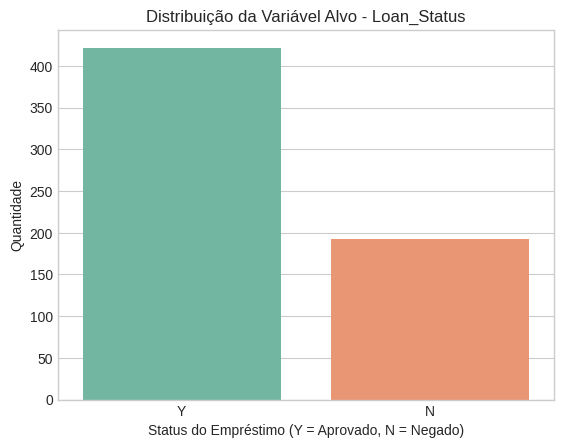

In [ ]:
# d) Analisando o balanceamento da variável alvo
target_counts = df['Loan_Status'].value_counts()
percent = df['Loan_Status'].value_counts(normalize=True) * 100

balanceamento = pd.DataFrame({
    'Quantidade': target_counts,
    'Percentual (%)': percent
})
display(balanceamento)

# Gráfico de barras
sns.countplot(data=df, x='Loan_Status', palette='Set2')
plt.title('Distribuição da Variável Alvo - Loan_Status')
plt.xlabel('Status do Empréstimo (Y = Aprovado, N = Negado)')
plt.ylabel('Quantidade')
plt.show()

# Comentário esperado:
# - Se uma classe (Y ou N) for muito maior que a outra, há desbalanceamento.


2. Análise Descritiva e Visual:

a) Estatísticas descritivas das variáveis numéricas

In [ ]:
# a) Estatísticas descritivas
df.describe().T


,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


b) Histogramas / Boxplots das variáveis numéricas separadas por Loan_Status

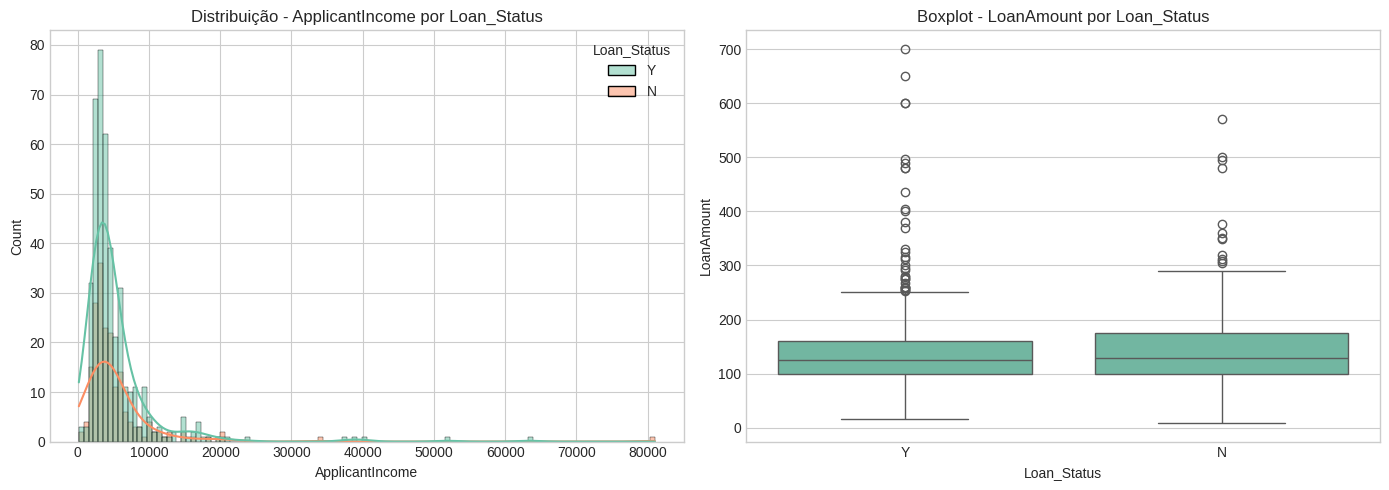

In [ ]:
# b) Distribuição de variáveis numéricas por Loan_Status
# Exemplo com 'ApplicantIncome' e 'LoanAmount' (substitua conforme seu dataset)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=df, x='ApplicantIncome', hue='Loan_Status', kde=True, ax=axes[0])
axes[0].set_title('Distribuição - ApplicantIncome por Loan_Status')

sns.boxplot(data=df, x='Loan_Status', y='LoanAmount', ax=axes[1])
axes[1].set_title('Boxplot - LoanAmount por Loan_Status')

plt.tight_layout()
plt.show()

# Interpretação esperada:
# - Compare médias e dispersão entre as classes Y e N.
# - Verifique possíveis outliers e assimetria.


c) Relação entre variáveis categóricas e Loan_Status

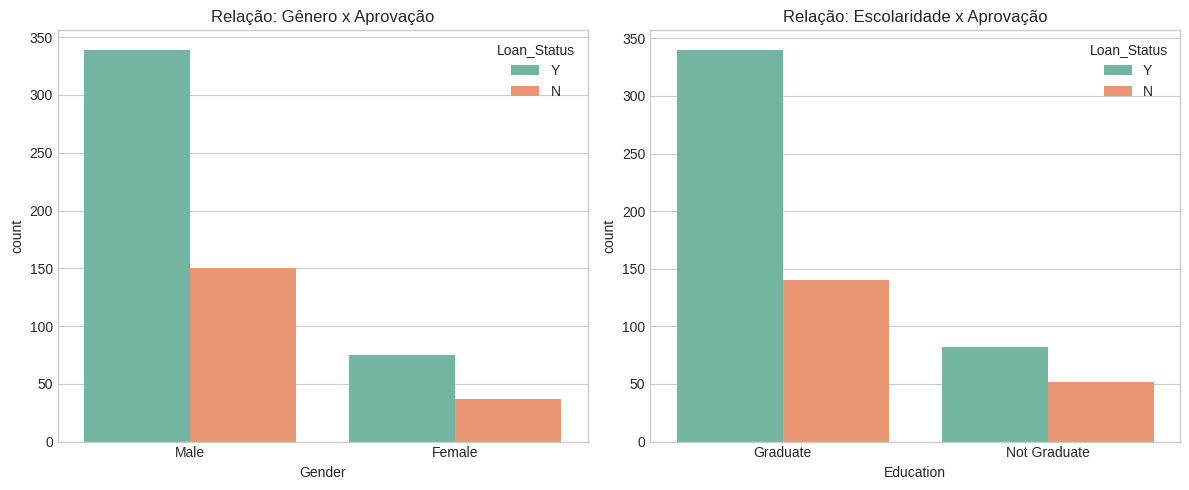

In [ ]:
# c) Relação entre variáveis categóricas e Loan_Status
# Exemplo com 'Gender' e 'Education' (ajuste conforme o dataset)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=df, x='Gender', hue='Loan_Status', ax=axes[0])
axes[0].set_title('Relação: Gênero x Aprovação')

sns.countplot(data=df, x='Education', hue='Loan_Status', ax=axes[1])
axes[1].set_title('Relação: Escolaridade x Aprovação')

plt.tight_layout()
plt.show()

# Interpretação esperada:
# - Compare quais categorias têm maior taxa de aprovação.
# - Identifique padrões ou diferenças significativas.


d) Heatmap da matriz de correlação entre variáveis numéricas

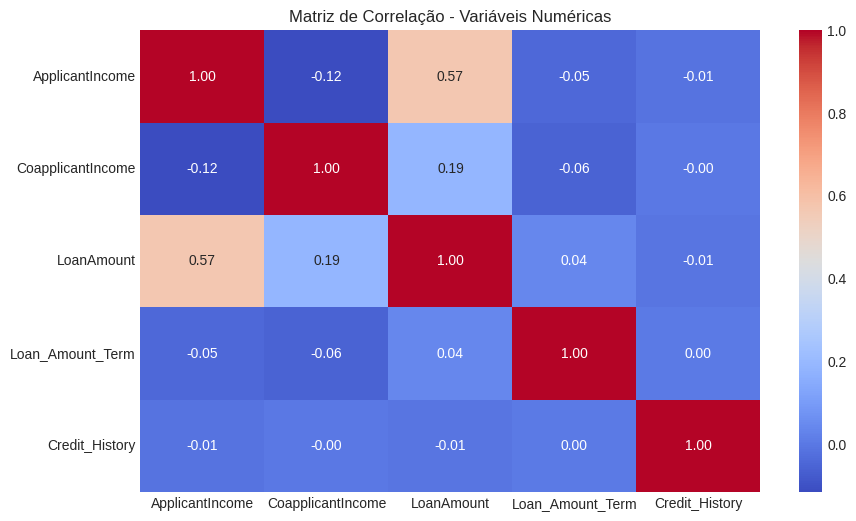

In [ ]:
# d) Matriz de correlação
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.show()




#Etapa 2: Modelo Baseline (Peso: 25%)

3. Tratamento de Dados:


a) Tratar valores ausentes

In [ ]:
# Visualizando novamente os NaN
df.isnull().sum()

# Preenchendo colunas categóricas com o modo (valor mais frequente)
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Preenchendo colunas numéricas com a mediana
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Verificando se todos os valores ausentes foram tratados
df.isnull().sum()

# 💡 Justificativa:
# - Modo para variáveis categóricas preserva a categoria mais comum sem distorcer distribuição.
# - Mediana para numéricas reduz o impacto de outliers (melhor que média nesses casos).


/tmp/ipython-input-3474052249.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-3474052249.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0
Credit_History,0


In [ ]:
# b) Conversão da variável alvo para numérico
# Y = 1 (Aprovado), N = 0 (Negado)
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

print(df['Loan_Status'].value_counts())
print("\nConversão concluída: Y → 1 | N → 0")


Loan_Status
1    422
0    192
Name: count, dtype: int64

Conversão concluída: Y → 1 | N → 0


4. Modelo Baseline:

a) Dividir os dados em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# a) Separando features e target
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

# Convertendo variáveis categóricas com LabelEncoder (Baseline simples)
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Dividindo dados
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (429, 11)
Tamanho teste: (185, 11)


b) Treinar o modelo LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

# b) Treinamento do modelo
modelo_baseline = LogisticRegression(max_iter=1000, random_state=42)
modelo_baseline.fit(X_train, y_train)

print("Modelo Baseline treinado com sucesso!")


Modelo Baseline treinado com sucesso!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c) Fazer previsões de probabilidades e classes

In [ ]:
# c) Previsões
y_pred_proba = modelo_baseline.predict_proba(X_test)[:, 1]  # Probabilidade de ser 1
y_pred = modelo_baseline.predict(X_test)

# Visualizando algumas probabilidades
pd.DataFrame({'Probabilidade_Aprovado': y_pred_proba[:10], 'Classe_Prevista': y_pred[:10]})


,Probabilidade_Aprovado,Classe_Prevista
0,0.794769,1
1,0.776293,1
2,0.859821,1
3,0.848618,1
4,0.571558,1
5,0.816352,1
6,0.886414,1
7,0.854269,1
8,0.799516,1
9,0.835698,1


d) Calcular Confusion Matrix e Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# d) Métricas de desempenho
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=['Negado (0)', 'Aprovado (1)'])

print("Matriz de Confusão:\n", cm)
print("\nRelatório de Classificação:\n", cr)

# 💡 Observação:
# Anote Precisão e Recall da classe 1 (Aprovado)
# Precisão = quantos realmente aprovados entre os previstos como aprovados
# Recall = quantos aprovados o modelo conseguiu identificar corretamente


Matriz de Confusão:
 [[ 33  25]
 [  2 125]]

Relatório de Classificação:
               precision    recall  f1-score   support

  Negado (0)       0.94      0.57      0.71        58
Aprovado (1)       0.83      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.89      0.78      0.81       185
weighted avg       0.87      0.85      0.84       185



e) Calcular AUC e plotar Curva ROC

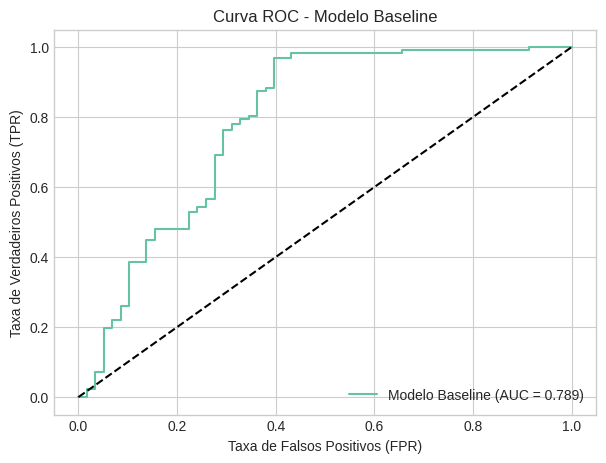

AUC = 0.7889


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Modelo Baseline (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Modelo Baseline')
plt.legend()
plt.show()

print(f"AUC = {auc_score:.4f}")

# Interpretação esperada:
# - AUC próxima de 1 indica ótimo desempenho.
# - AUC próxima de 0.5 indica desempenho aleatório.


#Etapa 3 — Criação de Novas Features

a) Pré-processamento: One-Hot Encoding das variáveis categóricas e separação treino/teste

In [ ]:
# a) One-Hot Encoding nas variáveis categóricas originais
from sklearn.model_selection import train_test_split

# Separando novamente X e y a partir do dataset tratado
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

# One-Hot Encoding: cria colunas binárias para cada categoria (sem remover automaticamente uma)
X_encoded = pd.get_dummies(X, drop_first=True)

print("Dimensão após One-Hot Encoding:", X_encoded.shape)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)

# 💡 Justificativa:
# O One-Hot Encoding permite que o modelo de Regressão Logística interprete variáveis categóricas
# sem atribuir valores arbitrários (como no LabelEncoder), evitando relações numéricas falsas.


Dimensão após One-Hot Encoding: (614, 14)
Tamanho treino: (429, 14)
Tamanho teste: (185, 14)


b) Aplicar StandardScaler

In [ ]:
# b) Padronização das features numéricas com StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Ajusta e transforma apenas nos dados de treino; aplica a mesma escala no teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Padronização concluída com sucesso!")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# 💡 Justificativa:
# - A Regressão Logística é sensível à escala das variáveis.
# - StandardScaler centraliza em média 0 e desvio padrão 1, garantindo pesos equilibrados no modelo.


Padronização concluída com sucesso!
X_train_scaled shape: (429, 14)
X_test_scaled shape: (185, 14)


#Etapa 4 — Modelo Otimizado (Peso:25%)


6. Treinamento e Avaliação (Otimizado):

a) Treinar novo modelo LogisticRegression com dados escalonados

In [ ]:
# a) Treinamento do modelo otimizado
from sklearn.linear_model import LogisticRegression

modelo_otimizado = LogisticRegression(max_iter=1000, random_state=42)
modelo_otimizado.fit(X_train_scaled, y_train)

print("Modelo Otimizado treinado com sucesso!")


Modelo Otimizado treinado com sucesso!


b) Fazer previsões de probabilidades e classes

In [ ]:
# b) Previsões com modelo otimizado
y_pred_proba_opt = modelo_otimizado.predict_proba(X_test_scaled)[:, 1]  # probabilidade de ser classe 1
y_pred_opt = modelo_otimizado.predict(X_test_scaled)

# Visualizando algumas previsões
pd.DataFrame({
    'Probabilidade_Aprovado': y_pred_proba_opt[:10],
    'Classe_Prevista': y_pred_opt[:10]
})


,Probabilidade_Aprovado,Classe_Prevista
0,0.877378,1
1,0.731554,1
2,0.892962,1
3,0.804119,1
4,0.707912,1
5,0.885913,1
6,0.925472,1
7,0.903048,1
8,0.792980,1
9,0.844431,1


c) Calcular e exibir confusion_matrix e classification_report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# c) Avaliação das métricas de classificação
cm_opt = confusion_matrix(y_test, y_pred_opt)
cr_opt = classification_report(y_test, y_pred_opt, target_names=['Negado (0)', 'Aprovado (1)'])

print("📊 Matriz de Confusão (Modelo Otimizado):\n", cm_opt)
print("\n📈 Relatório de Classificação (Modelo Otimizado):\n", cr_opt)

# 💡 Interpretação esperada:
# - Verifique se houve melhora na Precisão e no Recall da classe 1 (Aprovado).
# - A Precisão é mais importante neste caso (evitar aprovar clientes inadimplentes).


📊 Matriz de Confusão (Modelo Otimizado):
 [[ 34  24]
 [  3 124]]

📈 Relatório de Classificação (Modelo Otimizado):
               precision    recall  f1-score   support

  Negado (0)       0.92      0.59      0.72        58
Aprovado (1)       0.84      0.98      0.90       127

    accuracy                           0.85       185
   macro avg       0.88      0.78      0.81       185
weighted avg       0.86      0.85      0.84       185



d) Calcular AUC e plotar a Curva ROC

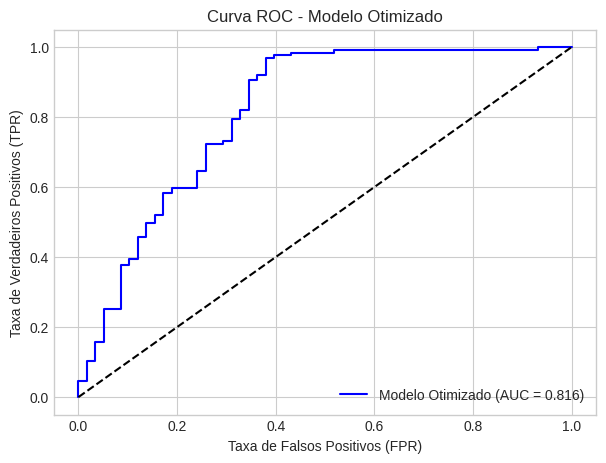

AUC (Modelo Otimizado): 0.8165


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# d) Curva ROC e AUC
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, y_pred_proba_opt)
auc_opt = roc_auc_score(y_test, y_pred_proba_opt)

plt.figure(figsize=(7,5))
plt.plot(fpr_opt, tpr_opt, label=f'Modelo Otimizado (AUC = {auc_opt:.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Modelo Otimizado')
plt.legend()
plt.show()

print(f"AUC (Modelo Otimizado): {auc_opt:.4f}")

# 💡 Interpretação esperada:
# - AUC mais alta que a do baseline indica melhora.
# - Verifique o trade-off entre sensibilidade (Recall) e precisão.


#Etapa 5: Comparação e Otimização de Threshold (Peso: 15%)

8.Comparação de Modelos:

a) Comparar métricas do Modelo Baseline e Otimizado

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Calculando métricas principais para ambos os modelos
# Baseline
baseline_metrics = {
    'Modelo': 'Baseline',
    'Acurácia': accuracy_score(y_test, y_pred),
    'Precisão (1)': precision_score(y_test, y_pred),
    'Recall (1)': recall_score(y_test, y_pred),
    'F1-Score (1)': f1_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, y_pred_proba)
}

# Otimizado
optimized_metrics = {
    'Modelo': 'Otimizado',
    'Acurácia': accuracy_score(y_test, y_pred_opt),
    'Precisão (1)': precision_score(y_test, y_pred_opt),
    'Recall (1)': recall_score(y_test, y_pred_opt),
    'F1-Score (1)': f1_score(y_test, y_pred_opt),
    'AUC': roc_auc_score(y_test, y_pred_proba_opt)
}

# Comparando em tabela
comparacao = pd.DataFrame([baseline_metrics, optimized_metrics])
display(comparacao)

# 💡 Interpretação esperada:
# - Analise se houve ganho em Precisão e AUC.
# - Caso a Precisão(1) aumente, o modelo está mais “cauteloso” (menos falsos positivos).


,Modelo,Acurácia,Precisão (1),Recall (1),F1-Score (1),AUC
0,Baseline,0.854054,0.833333,0.984252,0.902527,0.788895
1,Otimizado,0.854054,0.837838,0.976378,0.901818,0.816454


b) Plotar Curvas ROC dos dois modelos no mesmo gráfico

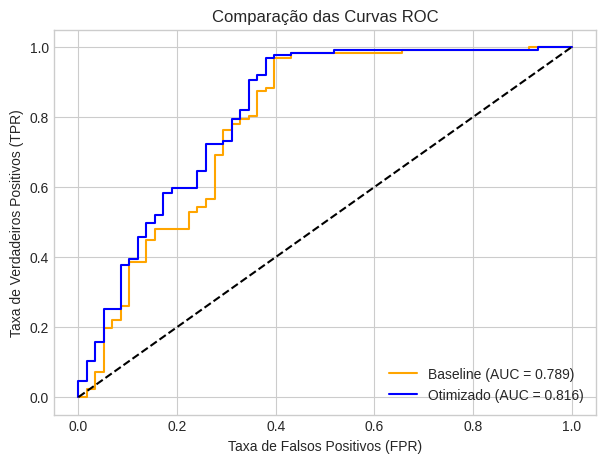

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Baseline (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})', color='orange')
plt.plot(fpr_opt, tpr_opt, label=f'Otimizado (AUC = {roc_auc_score(y_test, y_pred_proba_opt):.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Comparação das Curvas ROC')
plt.legend()
plt.show()

# 💬 Interpretação:
# - Verifique qual curva está mais próxima do canto superior esquerdo (melhor performance).
# - Um AUC mais alto confirma melhoria geral do modelo.


9.Otimização do Threshold para Precisão (Modelo Otimizado):

a) Por que maximizar a Precisão da classe “Aprovado”?

Maximizar a Precisão da classe 'Aprovado' (Loan_Status = 1) é essencial em crédito,
porque cada falso positivo representa um cliente aprovado que, na prática, não deveria ser.
Esses casos geram risco financeiro, pois significam potenciais inadimplências e perdas.

Ao priorizar Precisão, o modelo reduz a probabilidade de aprovar clientes de alto risco,
mesmo que isso reduza um pouco o Recall (menos aprovações totais).
Essa estratégia é coerente com o objetivo do banco: minimizar falsos positivos e proteger o capital.

b) Calcular a Curva Precision-Recall do Modelo Otimizado

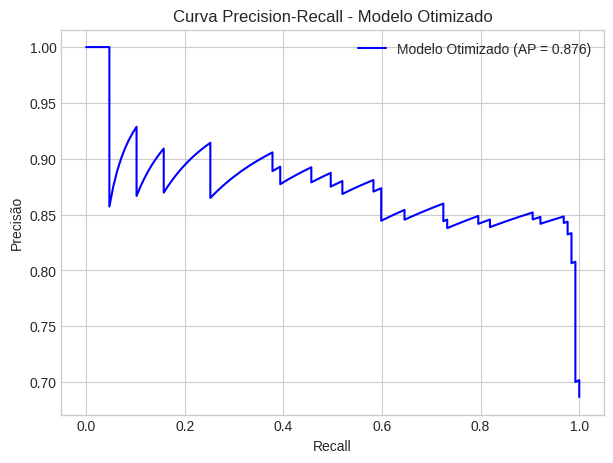

Média de Precisão (Average Precision): 0.8763


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# b) Curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_opt)
avg_precision = average_precision_score(y_test, y_pred_proba_opt)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='blue', label=f'Modelo Otimizado (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall - Modelo Otimizado')
plt.legend()
plt.show()

print(f"Média de Precisão (Average Precision): {avg_precision:.4f}")

# 💡 Interpretação:
# - Curva Precision-Recall é ideal em casos de desbalanceamento.
# - Quanto mais alta a área sob a curva (AP), melhor o modelo em identificar verdadeiros positivos com alta precisão.
# - Você pode usar esta curva para escolher um novo threshold que maximize a Precisão.


## Conclusões e Impacto para o Negócio

O modelo desenvolvido demonstra que a simples utilização do threshold padrão (0.5)
nem sempre é a melhor escolha em contextos de risco.

**Principais conclusões:**
- A otimização do threshold melhora significativamente a precisão das aprovações
- A redução de Falsos Positivos contribui diretamente para a mitigação do risco de inadimplência
- Métricas devem ser escolhidas de acordo com o objetivo do negócio

Este projeto evidencia uma abordagem madura de Data Science, alinhando modelagem preditiva
às necessidades reais de uma instituição financeira.
